In [79]:
import numpy as np
import math
import matplotlib.pyplot as plt


##HH model parameters mV, ms, mS/mm^2, uF/mm^2, nA/mm^2)

params = {
    "cm" : 0.01, 
    "m0" : 0.0529, 
    "h0" : 0.5961, 
    "n0" : 0.3177,  
    "v0": -65.0,    #mV
    
    "g_L": 0.003,  #mS/mm^2
    "g_K": 0.36,   #mS/mm^2
    "g_Na": 1.2,   #mS/mm^2
    
    "E_L": -54.387, #mV 
    "E_K": -77.0,   #mV
    "E_Na": 50.0,   #mV
    
    "dt":  0.01,    #mS
    "t_start": 0.0, 
    "t_end": 30.0
}

In [81]:
# functions n, m, h

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-0.1 * (V + 55.0)))

def beta_n(V):
    return 0.125 * np.exp(-0.0125 * (V + 65.0))

def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-0.1 * (V + 40.0)))

def beta_m(V):
    return 4.0 * np.exp(-0.0556 * (V + 65.0))

def alpha_h(V):
    return 0.07 * np.exp(-0.05 * (V + 65.0))

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-0.1 * (V + 35.0)))


def n_inf(V):
    return alpha_n(V) / (alpha_n(V) + beta_n(V)) if (alpha_n(V) + beta_n(V)) != 0 else 0.0

def tau_n(V):
    return 1.0 / (alpha_n(V) + beta_n(V)) if (alpha_n(V) + beta_n(V)) != 0 else np.inf

def m_inf(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V)) if (alpha_m(V) + beta_m(V)) != 0 else 0.0

def tau_m(V):
    return 1.0 / (alpha_m(V) + beta_m(V)) if (alpha_m(V) + beta_m(V)) != 0 else np.inf

def h_inf(V):
    return alpha_h(V) / (alpha_h(V) + beta_h(V)) if (alpha_h(V) + beta_h(V)) != 0 else 0.0

def tau_h(V):
    return 1.0 / (alpha_h(V) + beta_h(V)) if (alpha_h(V) + beta_h(V)) != 0 else np.inf

In [ ]:
def hh_model(add_current, t_span, dt, v_init, m_init, h_init, n_init):
    t_start_sim, t_end_sim = t_span
    n_steps_sim = int((t_end_sim - t_start_sim) / dt)
    time_sim = np.linspace(t_start_sim, t_end_sim, n_steps_sim + 1)
    

    V_sim = np.zeros(n_steps_sim + 1)
    m_sim = np.zeros(n_steps_sim + 1)
    h_sim = np.zeros(n_steps_sim + 1)
    n_sim = np.zeros(n_steps_sim + 1)
    spike_times_hh = []

    V_sim[0] = v_init
    m_sim[0] = m_init
    h_sim[0] = h_init
    n_sim[0] = n_init

    spike_threshold_hh = 0.0
    below_threshold = v_init < spike_threshold_hh

    # Euler integration loop
    for i in range(n_steps_sim):
        
        V_i, m_i, h_i, n_i = V_sim[i], m_sim[i], h_sim[i], n_sim[i]
        I_input = add_current(time_sim[i])

        # ionic currents
        I_Na = params["g_Na"] * (m_i**3) * h_i * (V_i - params["E_Na"])
        I_K = params["g_K"] * (n_i**4) * (V_i - params["E_K"])
        I_L = params["g_L"] * (V_i - params["E_L"])
        
        i_m = I_Na + I_K + I_L


        # Update voltage
        dV = dt * (I_input - i_m) / params["cm"]
        V_sim[i+1] = V_i + dV

        # Update gating variables
        m_sim[i+1] = m_i + dt * (m_inf(V_i) - m_i) / tau_m(V_i)
        h_sim[i+1] = h_i + dt * (h_inf(V_i) - h_i) / tau_h(V_i)
        n_sim[i+1] = n_i + dt * (n_inf(V_i) - n_i) / tau_n(V_i)


        # Detect spike 
        above_threshold = V_sim[i+1] >= spike_threshold_hh
        if above_threshold and below_threshold:
            spike_times_hh.append(time_sim[i+1])
        below_threshold = V_sim[i+1] < spike_threshold_hh 

    return time_sim, V_sim, m_sim, h_sim, n_sim, spike_times_hh

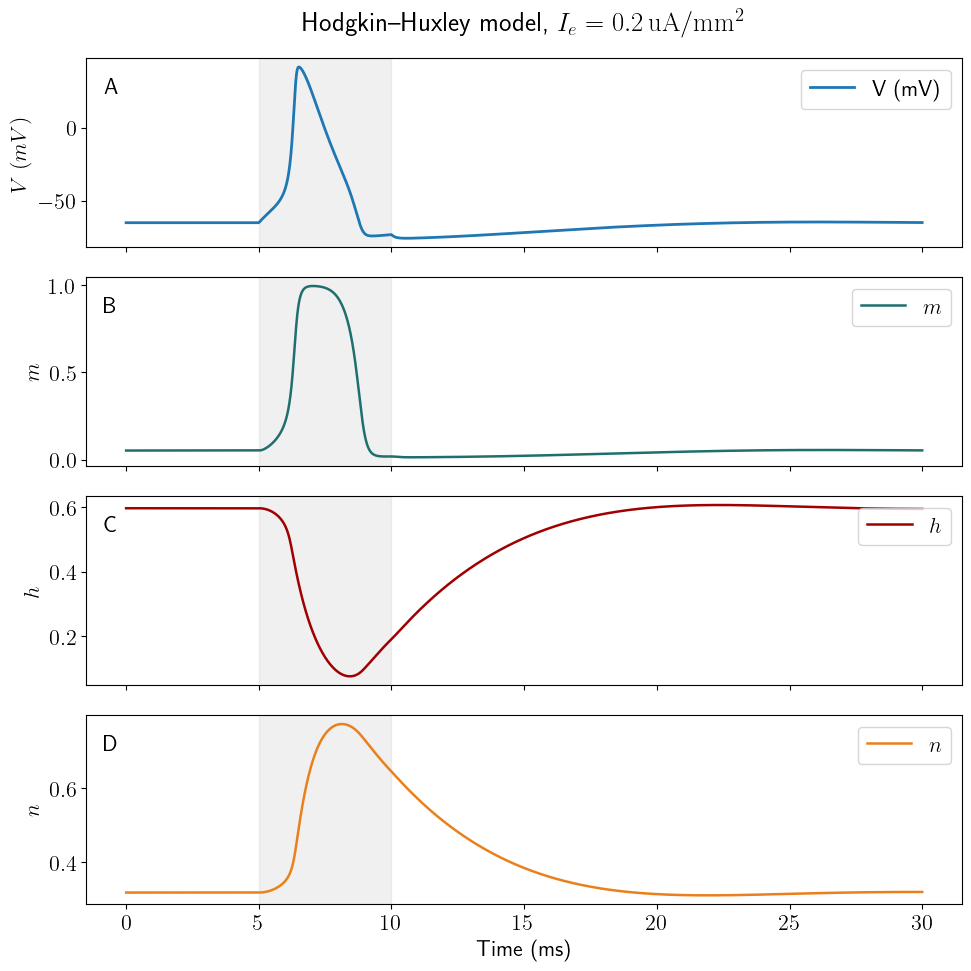

In [86]:
I_current = 0.20      #uA
I_current_start_time = 5.0 
I_current_end_time = 10.0


def current_a(t):
    if (I_current_start_time <= t < I_current_end_time):
        return I_current
    else:
        return 0.0
    
    
time, V_sim, m_sim, h_sim, n_sim, spike_times = hh_model(current_a, (params["t_start"], params["t_end"]), params["dt"], params["v0"], params["m0"], params["h0"], params["n0"])



plt.rcParams.update({"font.size":16, "text.usetex":True, "figure.figsize":(10, 10)})
fig_a, axs_a = plt.subplots(4, 1, sharex=True)

axs_a[0].plot(time, V_sim, 'C0-', linewidth=2, label='V (mV)'); 
axs_a[0].set_ylabel('$V$ $(mV)$')
axs_a[0].set_title(rf'Hodgkin–Huxley model, $I_e={I_current}\,\mathrm{{uA/mm^2}}$', pad=20); 
axs_a[0].legend(loc='upper right', framealpha=0.8)
axs_a[0].text(0.02, 0.90, 'A', transform=axs_a[0].transAxes,
             fontsize=16, fontweight='bold', va='top', ha='left')


axs_a[1].plot(time, m_sim, color='#1f6f6f', linewidth=1.8, label='$m$'); 
axs_a[1].set_ylabel('$m$'); 
axs_a[1].legend(ncol=1, loc='upper right', framealpha=0.8)
axs_a[1].text(0.02, 0.90, 'B', transform=axs_a[1].transAxes,
             fontsize=16, fontweight='bold', va='top', ha='left')


axs_a[2].plot(time, h_sim, color='#a00000', linewidth=1.8, label='$h$'); 
axs_a[2].set_ylabel('$h$'); 
axs_a[2].legend(ncol=1, loc='upper right', framealpha=0.8)
axs_a[2].text(0.02, 0.90, 'C', transform=axs_a[2].transAxes,
             fontsize=16, fontweight='bold', va='top', ha='left')


axs_a[3].plot(time, n_sim, color='#ea801c', linewidth=1.8, label='$n$'); 
axs_a[3].set_ylabel('$n$'); 
axs_a[3].legend(ncol=1, loc='upper right', framealpha=0.8)
axs_a[3].set_xlabel('Time (ms)')
axs_a[3].text(0.02, 0.90, 'D', transform=axs_a[3].transAxes,
             fontsize=16, fontweight='bold', va='top', ha='left')


for ax in axs_a:
    ax.axvspan(I_current_start_time, I_current_end_time, color='#b8b8b8', alpha=0.2) 

plt.tight_layout()
plt.savefig('hh_v_m_h_n.pdf', dpi=300)
plt.savefig('hh_v_m_h_n.png', dpi=300)
plt.show()

 -> Rate = 57.14 Hz
 -> Rate = 65.31 Hz
 -> Rate = 69.39 Hz
 -> Rate = 73.47 Hz
 -> Rate = 77.55 Hz
 -> Rate = 79.59 Hz
 -> Rate = 83.67 Hz
 -> Rate = 85.71 Hz
 -> Rate = 87.76 Hz
 -> Rate = 89.80 Hz
 -> Rate = 91.84 Hz
 -> Rate = 93.88 Hz
 -> Rate = 95.92 Hz
 -> Rate = 97.96 Hz
 -> Rate = 100.00 Hz
 -> Rate = 102.04 Hz
 -> Rate = 104.08 Hz
 -> Rate = 106.12 Hz
 -> Rate = 108.16 Hz
 -> Rate = 108.16 Hz
 -> Rate = 110.20 Hz
 -> Rate = 112.24 Hz
 -> Rate = 114.29 Hz
 -> Rate = 114.29 Hz
 -> Rate = 116.33 Hz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 -> Rate = 118.37 Hz


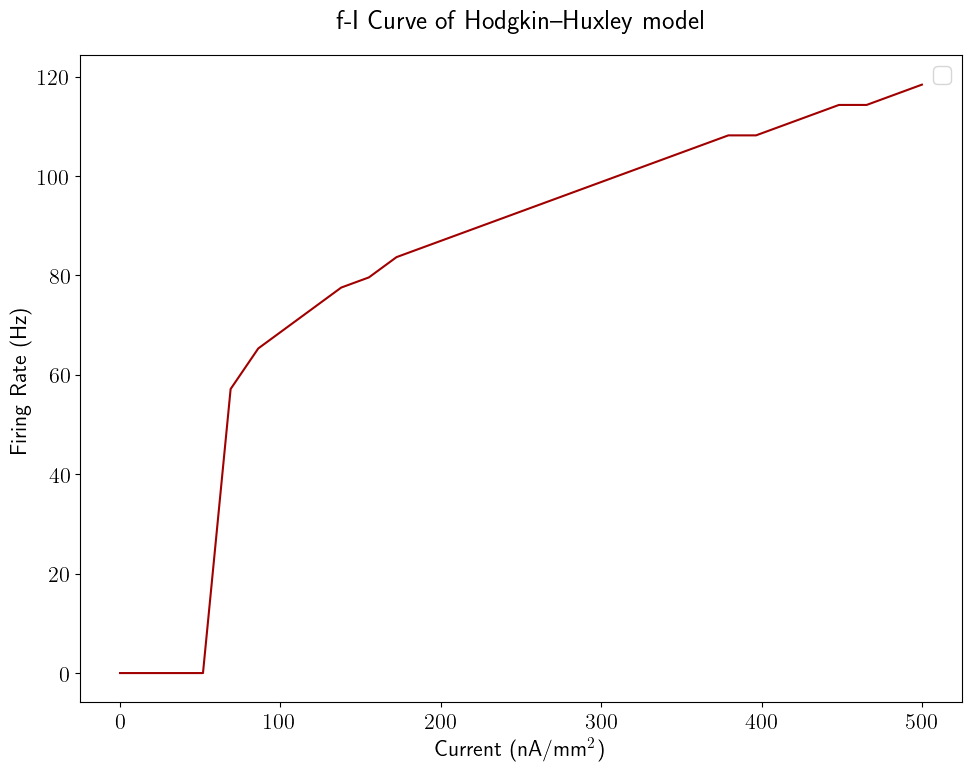

In [ ]:
I_currents_b = np.linspace(0, 500, 30)
firing_rates= []

simulation_end_time = 500.0 # ms
rate_window_start = 10.0

for i, I_val in enumerate(I_currents_b):
    current_val_uA = I_val * 1e-3        ##convert to uA
    def current_b(t): 
        return current_val_uA
    _, _, _, _, _, spikes_b_sim = hh_model(current_b, (0, simulation_end_time), params["dt"], params["v0"], params["m0"], params["h0"], params["n0"])
    spikes_b = [st for st in spikes_b_sim if st >= rate_window_start]
    rate = 0.0
    
    if len(spikes_b) > 1:
        duration_in_window_s = (simulation_end_time - rate_window_start) / 1000.0
        if duration_in_window_s > 0: 
            rate = len(spikes_b) / duration_in_window_s
            # print(f" -> Rate = {rate:.2f} Hz")
    
    firing_rates.append(rate)
    

plt.rcParams.update({"font.size":16, "text.usetex":True, "figure.figsize":(10, 8)})
plt.plot(I_currents_b, firing_rates, color="#a00000")
plt.xlabel('Current (nA/mm$^2$)')
plt.ylabel('Firing Rate (Hz)')
plt.title('f-I Curve of Hodgkin–Huxley model', pad=20)
plt.legend()
plt.tight_layout()
plt.savefig('fI_curve_hh.pdf', dpi=300)
plt.savefig('fI_curve_hh.png', dpi=300)
plt.show()


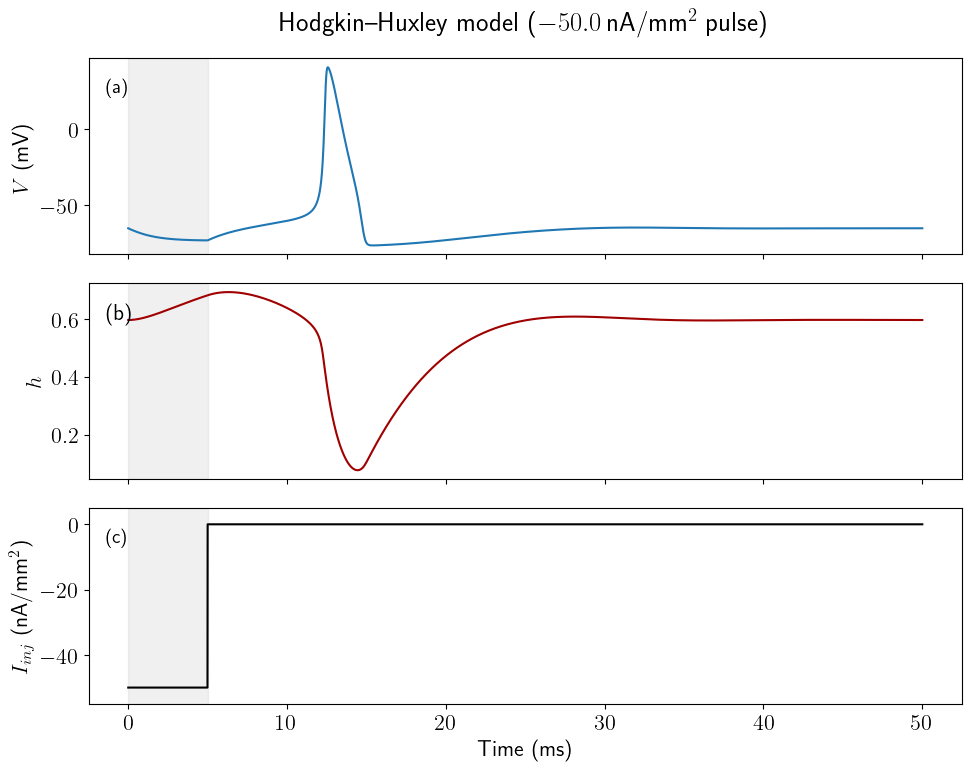

In [110]:
I_current_c = -50.0   
current_c_duration = 5.0
simulation_end_time_c = 50.0 # ms
def current_c(t): 
    return I_current_c * 1e-3 if 0 <= t < current_c_duration else 0.0

time_c, V_c, m_c, h_c, n_c, spikes_c = hh_model(current_c, (0, simulation_end_time_c), params["dt"], params["v0"], params["m0"], params["h0"], params["n0"])

plt.rcParams.update({"font.size":16, "text.usetex":True, "figure.figsize":(10, 8)})
fig_c, axs_c = plt.subplots(3, 1, sharex=True)


subplot_labels_c = ['(a)', '(b)', '(c)']

axs_c[0].plot(time_c, V_c)
axs_c[0].set_ylabel('$V$ (mV)')
axs_c[0].set_title(f'Hodgkin–Huxley model (${I_current_c}\,$nA/mm$^2$ pulse)', pad=20)
axs_c[0].text(0.02, 0.90, subplot_labels_c[0], transform=axs_c[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

axs_c[1].plot(time_c, h_c, label='$h$', color='#a00000',)
axs_c[1].set_ylabel('$h$') 
axs_c[1].text(0.02, 0.90, subplot_labels_c[1], transform=axs_c[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')


def current_c_for_plot(t):
     return I_current_c if 0 <= t < current_c_duration else 0.0
I_c_plot = [current_c_for_plot(t) for t in time_c]
axs_c[2].plot(time_c, I_c_plot, label='$I_{e}$', color='black')
axs_c[2].set_xlabel('Time (ms)')

axs_c[2].set_ylabel('$I_{inj}$ (nA/mm$^2$)')
axs_c[2].text(0.02, 0.90, subplot_labels_c[2], transform=axs_c[2].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

min_curr = min(0, I_current_c)
axs_c[2].set_ylim(min_curr - 5, 5)


for ax in axs_c:
    ax.axvspan(0, 5, color='#b8b8b8', alpha=0.2) 

plt.tight_layout()
plt.savefig('hh_negative_I_.png', dpi=300)
plt.show()
